# ***Plagiarism Detection after Sampling process***

*Initiliasing all the libraries in the beginning*

In [ ]:
# !pip install fast_ml
# from fast_ml.model_development import train_valid_test_split
!pip install -q -U keras-tuner
!pip install visualkeras

     |████████████████████████████████| 133 kB 33.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 24.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import re
import imblearn
import collections
import seaborn as sns

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers,layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy,CategoricalCrossentropy
from keras.models import model_from_json
from matplotlib import pyplot as plt


***Geting the feature dataset and label using pandas***

In [ ]:
df=pd.read_csv('/content/sample_data/plagiarism_student_dataset_features.csv',index_col=0)
df.index.names=[None]
print(df.dtypes)
df.describe()
sns.set(style = 'whitegrid')

total_time               float64
compiled                 float64
compiled_successfully    float64
ran_tests                float64
test_results             float64
modified                 float64
add_lines                float64
change                   float64
remove_lines             float64
cps                      float64
paste_lines              float64
max_pastes               float64
average_test_results     float64
avg_paste                float64
dtype: object


In [ ]:
label_A=pd.read_csv('/content/sample_data/label_for_plagiarism_dataset_stat_dynamic.csv',index_col=0)
label_A.index.names=[None]
label_A.describe()

,label
count,2339.000000
mean,0.284310
std,0.451181
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.head()

,total_time,compiled,compiled_successfully,ran_tests,test_results,modified,add_lines,change,remove_lines,cps,paste_lines,max_pastes,average_test_results,avg_paste
A2016\student1013,6894752.0,1441.0,1116.0,689.0,1349.0,38441.0,12365.0,32597.0,2023.0,0.003436,5202.0,120.0,1.957910,4.553441
A2016\student1016,37440.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8.0,0.000000,NaN,NaN,NaN,NaN
A2016\student1021,9363152.0,2108.0,1278.0,787.0,1605.0,58550.0,19160.0,49003.0,6105.0,0.003997,7270.0,162.0,2.039390,5.147455
A2016\student1029,6949656.0,1775.0,1201.0,852.0,754.0,36461.0,15605.0,30332.0,2683.0,0.005040,7235.0,165.0,0.884977,4.840774
A2016\student1066,2784368.0,338.0,223.0,449.0,810.0,13924.0,6140.0,12169.0,369.0,0.004970,3988.0,139.0,1.804009,3.470160


***Line Plot of the feature set showing the range of features***

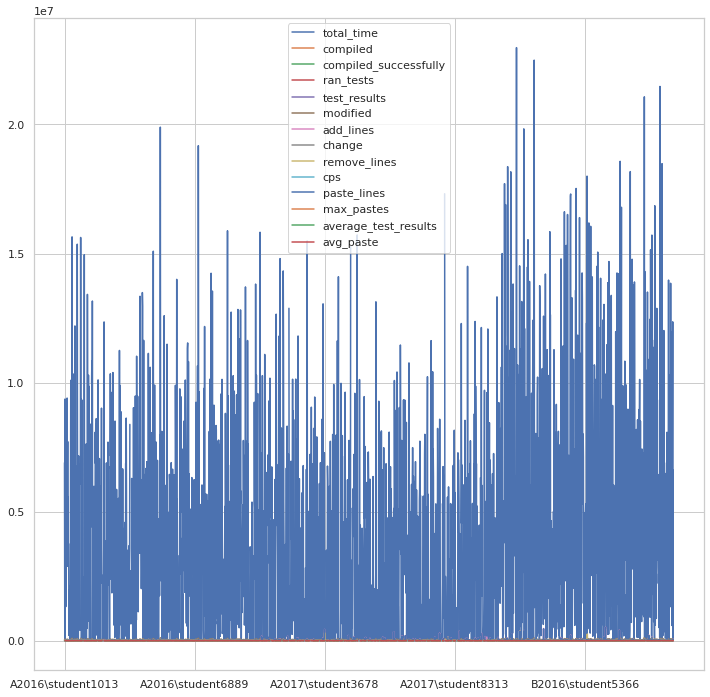

In [ ]:
df.plot(figsize=(12,12))

In [ ]:
label_A.head()

,label
A2016\student1013,0
A2016\student1016,0
A2016\student1021,1
A2016\student1029,1
A2016\student1066,0


In [ ]:
label_list = label_A['label'].tolist()

In [ ]:

print(label_list[:10])
print(len(label_list))

[0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
2339


In [ ]:
df['label']=label_list
df.fillna(0,inplace=True)
# df.dropna(inplace = True)
trainA=df.iloc[:,:-1]
label_A=df.iloc[:,-1]

In [ ]:
trainA.head()

,total_time,compiled,compiled_successfully,ran_tests,test_results,modified,add_lines,change,remove_lines,cps,paste_lines,max_pastes,average_test_results,avg_paste
A2016\student1013,6894752.0,1441.0,1116.0,689.0,1349.0,38441.0,12365.0,32597.0,2023.0,0.003436,5202.0,120.0,1.957910,4.553441
A2016\student1016,37440.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.000000,0.000000
A2016\student1021,9363152.0,2108.0,1278.0,787.0,1605.0,58550.0,19160.0,49003.0,6105.0,0.003997,7270.0,162.0,2.039390,5.147455
A2016\student1029,6949656.0,1775.0,1201.0,852.0,754.0,36461.0,15605.0,30332.0,2683.0,0.005040,7235.0,165.0,0.884977,4.840774
A2016\student1066,2784368.0,338.0,223.0,449.0,810.0,13924.0,6140.0,12169.0,369.0,0.004970,3988.0,139.0,1.804009,3.470160


In [ ]:
label_A.head()

A2016\student1013    0
A2016\student1016    0
A2016\student1021    1
A2016\student1029    1
A2016\student1066    0
Name: label, dtype: int64

***The count of plagiarised and not plagiarised dataset available to us which is skewed, as the count of not plagiarised is greater than the count of plagiarised***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


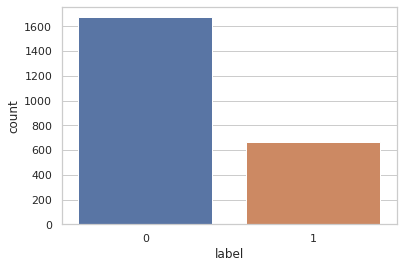

In [ ]:
sns.countplot(label_A)

***Scaling the values of features between 0 to 1 for better results and classification***

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
train_A=scaler.fit_transform(trainA)

In [ ]:
print(train_A.dtype)
print(train_A.shape)
print(train_A)

float64
(2339, 14)
[[3.00070017e-01 1.34384034e-01 1.52417372e-01 ... 6.00000000e-03
  1.95791002e-01 1.05267808e-02]
 [1.62944533e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.07498512e-01 1.96586776e-01 1.74542475e-01 ... 8.10000000e-03
  2.03939009e-01 1.19000408e-02]
 ...
 [5.37605544e-01 5.28676676e-01 4.87298552e-01 ... 1.16000000e-02
  6.28982528e-02 1.11948382e-02]
 [3.69758748e-04 0.00000000e+00 0.00000000e+00 ... 1.00000000e-04
  0.00000000e+00 3.39974979e-03]
 [2.87237439e-01 1.54714166e-01 1.35618683e-01 ... 1.62500000e-02
  1.02476780e-01 1.58131852e-02]]


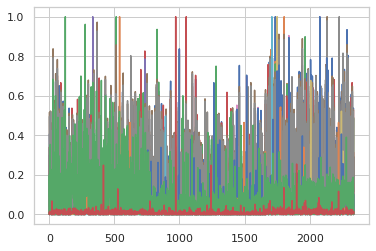

In [ ]:
plt.plot(train_A)

In [ ]:
label_A=label_A.to_numpy()
print(label_A.dtype)
# label_A=label_A.astype(float)
print(label_A.shape)
print(label_A)

int64
(2339,)
[0 0 1 ... 0 0 0]


***Splitting the dataset into training and testing with a train_size split of 0.8***

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(train_A,label_A,train_size=0.8,shuffle=True)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(sorted(Counter(y_train).items()))

(1871, 14)
(1871,)
(468, 14)
(468,)
[(0, 1342), (1, 529)]


In [ ]:
smote=imblearn.over_sampling.SMOTE(sampling_strategy='minority')
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 1341), (1, 1341)]


***As the dataset is skewed we sample it using the methods of both under sampling and over sampling which is achieved through smote enn and the sampling strategy we chose is minority***

In [ ]:
smote_enn = imblearn.combine.SMOTEENN(random_state=0,sampling_strategy='minority')
x_train_resampled, y_train_resampled = smote_enn.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 703), (1, 956)]


***This is the countplot after the sampling is performed***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


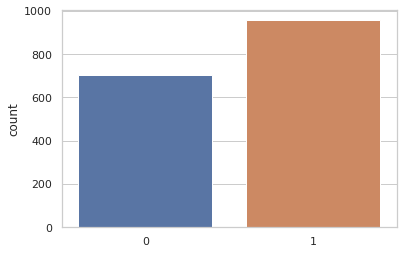

In [ ]:
sns.countplot(y_train_resampled)

***The callbacks are defined here to stop training the model when there is no change in the parameter we wish to monitor***

In [ ]:
# callbacks
# early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0, 
    mode='max',
    restore_best_weights=True

)
custom_early_stopping_loss = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0, 
    mode='min',
    restore_best_weights=True
)
custom_early_stopping_recall=EarlyStopping(
    monitor='val_recall', 
    patience=5, 
    min_delta=0, 
    mode='max',
    restore_best_weights=True
)

# reduce_lr callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=0, 
    mode="max",
    verbose=2
)
# lr_decay callback
def lr_decay(epoch, lr):
    if epoch != 0 and epoch % 5 == 0:
        return lr * 0.2
    return lr

# modelcheckpoint callback
filepath = 'my_best_model_acc{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
# callbacks = [checkpoint]

***A sequential model is built in the function using keras tuner which selects the best model for the inputs based on the range of layers given(2-40) and number of neurons between 16-512 with a step size of 32 and also the learning rate. It selects the best hyperparameters based on the input dataset provided***

In [ ]:
def build_model(hp):
  model=keras.Sequential()
  
  for layer in range(hp.Int('num_layers',2,40)):
    model.add(layers.Dense(units=hp.Int('units' + str(layer),
                                            min_value=16,
                                            max_value=512,
                                            step=32),
                               activation='relu')),
  model.add(layers.Dense(units=1,activation='sigmoid'))
  model.compile(optimizer=SGD(hp.Choice('learning_rate',[1e-2, 1e-3, 1e-4,1e-5,1e-6,1e-7,1e-8])),
                              loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
  return model 

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy",direction="max"),
    max_trials=4,
    executions_per_trial=5,
    directory='project2',
    overwrite=True,
    project_name='Plagiarism Detection')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 40, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08], 'ordered': True}


In [ ]:
tuner.search(x_train_resampled,
          y_train_resampled,
          epochs=100,
          validation_split=0.25,
          callbacks=[
                     custom_early_stopping,
                    reduce_lr]
                )

Trial 4 Complete [00h 01m 02s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.46066349744796753
Total elapsed time: 00h 02m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project2/Plagiarism Detection
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units0: 112
units1: 112
learning_rate: 0.001
units2: 240
units3: 176
units4: 304
units5: 208
units6: 464
units7: 16
units8: 368
units9: 144
units10: 336
units11: 496
units12: 464
units13: 432
units14: 272
units15: 272
units16: 176
units17: 272
units18: 144
units19: 368
units20: 368
units21: 48
units22: 368
units23: 368
units24: 208
units25: 400
units26: 496
units27: 144
units28: 368
units29: 112
units30: 208
units31: 112
units32: 112
units33: 432
units34: 368
units35: 304
Score: 0.46066349744796753
Trial summary
Hyperparameters:
num_layers: 36
units0: 240
units1: 272
learning_rate: 1e-08
units2: 16
units3: 16
units4: 16
units5: 16
units6: 16
units7: 16
units8: 16
units9: 16
units10: 16
units11: 16
units12: 16
units13: 16
units14: 16
units15: 16
units16: 16
units17: 16
units18: 16
units19: 16
units20: 16
units21: 16
units22: 16
units23: 16
units24: 16
units25: 16


***The model with best validation accuracy is chosen after searching it using RandomSearch***

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('num_layers'))
print(best_hps.get('learning_rate'))

3
0.001


***The best model is built and fit on the dataset. The model is also retrained to get better accuracy and recall values***

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_resampled, y_train_resampled, epochs=100, validation_split=0.25,callbacks=[custom_early_stopping,reduce_lr])
# val_acc_per_epoch=history.history['val_loss']
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
40/40 [==============================] - 1s 13ms/step - loss: 0.6975 - accuracy: 0.5685 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.7112 - val_accuracy: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5685 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5685 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.7117 - val_accuracy: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 3/100
22/40 [===============>..............] - ETA: 0s - loss: 0.6959 - accuracy: 0.5384 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
40/40 [==============================] - 

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train_resampled, y_train_resampled, epochs=best_epoch, validation_split=0.2,callbacks=[reduce_lr,custom_early_stopping])

43/43 [==============================] - 2s 14ms/step - loss: 0.6869 - accuracy: 0.7470 - precision_2: 0.6640 - recall_2: 0.9286 - val_loss: 0.6766 - val_accuracy: 0.9318 - val_precision_2: 1.0000 - val_recall_2: 0.9318 - lr: 0.0010


In [ ]:
from statistics import median, mode
eval_result = hypermodel.evaluate(x_test, y_test)
eval_result_train=hypermodel.evaluate(x_train_resampled,y_train_resampled)
eval_result
print("[test loss, test accuracy,test precision,test recall]:", eval_result)# print(predictions.dtype)
predictions=hypermodel.predict(x_test)

print(sum(predictions)/len(predictions))
print(median(predictions))
val=min(sum(predictions)/len(predictions),median(predictions))
predictions

53/53 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.8273 - precision_2: 0.8012 - recall_2: 0.9297
[test loss, test accuracy,test precision,test recall]: [0.6954474449157715, 0.5405982732772827, 0.3787878751754761, 0.9259259104728699]
[0.5059709]
[0.50354123]


array([[0.51376194],
       [0.50781643],
       [0.5027408 ],
       [0.4990764 ],
       [0.5053578 ],
       [0.5028323 ],
       [0.4991333 ],
       [0.5327133 ],
       [0.50258887],
       [0.5285369 ],
       [0.5080836 ],
       [0.5044049 ],
       [0.49912548],
       [0.5117953 ],
       [0.501682  ],
       [0.4990761 ],
       [0.50270665],
       [0.49936494],
       [0.5092619 ],
       [0.49907503],
       [0.5114746 ],
       [0.50105184],
       [0.5078654 ],
       [0.49919617],
       [0.4990785 ],
       [0.49911734],
       [0.5011914 ],
       [0.5137399 ],
       [0.51057553],
       [0.5119382 ],
       [0.5009475 ],
       [0.50524575],
       [0.50150293],
       [0.49907407],
       [0.5207939 ],
       [0.5091077 ],
       [0.5024663 ],
       [0.50918067],
       [0.4991221 ],
       [0.4990741 ],
       [0.49912933],
       [0.5132318 ],
       [0.4992469 ],
       [0.5015606 ],
       [0.5010841 ],
       [0.49907595],
       [0.49907467],
       [0.511

*Here is the graph showing the performance of the training and testing data after fitting the model on the dataset after first try*

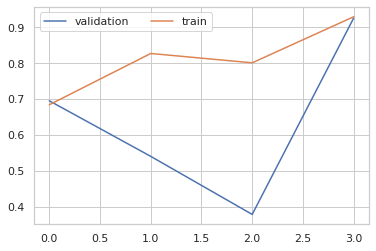

In [ ]:
plt.plot(eval_result,label="test")
plt.plot(eval_result_train,label="train")
plt.legend(ncol=2)

In [ ]:
print(predictions.shape)
seq_predictions=np.transpose(predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x< val else 1, seq_predictions))

(468, 1)
(468,)


In [ ]:
for i in seq_predictions:
  print(i)

1
1
0
0
1
0
0
1
0
1
1
1
0
1
0
0
0
0
1
0
1
0
1
0
0
0
0
1
1
1
0
1
0
0
1
1
0
1
0
0
0
1
0
0
0
0
0
1
1
1
1
0
0
1
0
1
0
0
1
1
0
0
1
1
0
0
1
0
0
1
0
0
1
1
1
0
1
1
1
0
0
1
0
1
1
1
0
0
1
0
1
1
1
0
0
0
1
0
0
0
1
1
0
0
1
1
1
0
1
0
1
1
1
1
0
0
1
1
0
0
0
1
1
1
0
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
1
1
0
0
0
1
1
1
0
0
0
1
0
0
1
1
1
1
0
1
0
1
1
1
1
0
1
0
1
0
0
1
1
1
1
0
1
0
0
1
1
1
1
0
1
1
0
0
1
0
1
1
0
1
1
0
1
1
0
0
1
1
1
0
0
0
1
1
1
0
0
0
0
1
0
0
1
1
1
1
0
1
1
0
1
0
1
0
1
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
1
0
1
1
1
1
1
0
0
0
1
0
1
1
1
1
1
0
0
0
1
0
0
1
1
0
1
0
1
1
1
0
1
0
0
1
1
0
0
1
0
0
0
0
0
0
1
1
1
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
1
1
0
0
1
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
0
1
0
0
0
1
0
0
0
0
1
1
1
1
0
0
1
0
1
1
0
0
1
1
1
0
0
0
1
1
1
0
0
1
0
1
1
1
1
1
0
0
0
1
1
0
1
0
0
1
0
1
1
1
0
0
1
1
0
1
0
1
1
0
1
1
0
0
1
1
1
0
0
0
0
1
1
1
1
0
0
0
1
0
1
1
0
0
1
0
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0


In [ ]:
loss,acc,pre,rec=hypermodel.evaluate(x_train_resampled,y_train_resampled)
print(acc)
loss,acc,pre,rec=hypermodel.evaluate(x_test,y_test)
print(acc)

54/54 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.8786 - precision_2: 0.8278 - recall_2: 0.9895
0.878609299659729
15/15 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.6047 - precision_2: 0.4290 - recall_2: 0.9433
0.6047008633613586


In [ ]:
# save the file in json
model_json = hypermodel.to_json()
with open("model_acctest_69.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
hypermodel.save_weights("model_acctest_69.h5")
print("Saved model to disk")

In [ ]:
# load the model from json
json_file = open('model_acctest_69.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_acctest_69.h5")
print("Loaded model from disk")

Loaded model from disk


***The saved and loaded model is compiled and evaluated again on the training and test dataset to give us the following results***

In [ ]:
# loading the model from disk and calculating the recall and accuracy
loaded_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy',keras.metrics.Recall(),keras.metrics.AUC()])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
score_train=loaded_model.evaluate(x_train_resampled,y_train_resampled,verbose=0)
print("For testing data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score[3]*100))
print("For training data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score_train[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score_train[3]*100))

For testing data
accuracy: 63.25%
recall_1: 88.73%
auc_1: 73.35%
For training data
accuracy: 90.15%
recall_1: 95.92%
auc_1: 90.20%


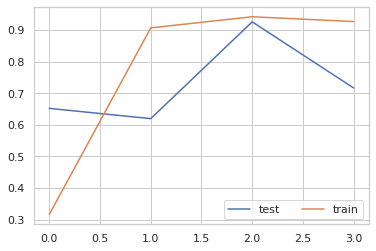

In [ ]:
plt.plot(score,label="test")
plt.plot(score_train,label="train")
plt.legend(ncol=2)

***The loaded model is compiled and fit again to give us better results of accuracy and recall which is 68.4 and 91.1 respectively after the sampling process***

In [ ]:
# retrain the model
loaded_model.fit(x_train_resampled,y_train_resampled,epochs=100,validation_split=0.2,use_multiprocessing=True,callbacks=[custom_early_stopping,reduce_lr])

Epoch 1/100
43/43 [==============================] - 1s 5ms/step - loss: 0.3238 - accuracy: 0.8923 - recall_1: 0.9626 - auc_1: 0.8964 - val_loss: 0.3307 - val_accuracy: 0.9441 - val_recall_1: 0.9441 - val_auc_1: 0.0000e+00 - lr: 0.0100
Epoch 2/100
30/43 [===================>..........] - ETA: 0s - loss: 0.3229 - accuracy: 0.8917 - recall_1: 0.9571 - auc_1: 0.8948
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
43/43 [==============================] - 0s 5ms/step - loss: 0.3184 - accuracy: 0.8931 - recall_1: 0.9642 - auc_1: 0.8987 - val_loss: 0.3528 - val_accuracy: 0.9353 - val_recall_1: 0.9353 - val_auc_1: 0.0000e+00 - lr: 0.0100
Epoch 3/100
30/43 [===================>..........] - ETA: 0s - loss: 0.3132 - accuracy: 0.8969 - recall_1: 0.9705 - auc_1: 0.8989
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
43/43 [==============================] - 0s 5ms/step - loss: 0.3141 - accuracy: 0.8968 - recall_1: 0.9675 - auc_1: 0.9012 - val_

In [ ]:
# save the file in json
model_json = loaded_model.to_json()
with open("model_acctest_69.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("model_acctest_69.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load the model from json
json_file = open('model_acctest_69.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_acctest_69.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# loading the model from disk and calculating the recall and accuracy
loaded_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy',keras.metrics.Recall(),keras.metrics.AUC()])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
score_train=loaded_model.evaluate(x_train_resampled,y_train_resampled,verbose=0)
print("For testing data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score[3]*100))
print("For training data")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score_train[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score_train[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score_train[3]*100))

For testing data
accuracy: 68.38%
recall_1: 94.12%
auc: 77.01%
For training data
accuracy: 89.69%
recall_1: 94.25%
auc: 90.35%


*The performance graph after fitting the model 2nd time for better performance*


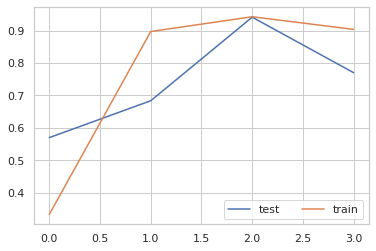

In [ ]:
plt.plot(score,label="test")
plt.plot(score_train,label="train")
plt.legend(ncol=2)

***Visualizing the neural network based on the density of each layer***

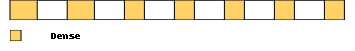

In [ ]:
import visualkeras
visualkeras.layered_view(loaded_model).show() # display using your system viewer
visualkeras.layered_view(loaded_model, to_file='output.png') # write to disk
visualkeras.layered_view(loaded_model, to_file='output.png').show() # write and show

visualkeras.layered_view(loaded_model, legend=True, draw_volume=False,spacing=30)

In [ ]:
from statistics import median, mode
eval_result = loaded_model.evaluate(x_test, y_test)
eval_result
print("[test loss, test accuracy,test precision,test recall]:", eval_result)
predictions=loaded_model.predict(x_test)

print(sum(predictions)/len(predictions))
print(median(predictions))
val=min(sum(predictions)/len(predictions),median(predictions))
predictions

15/15 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.6838 - recall_1: 0.9412 - auc: 0.7701
[test loss, test accuracy,test precision,test recall]: [0.5701486468315125, 0.6837607026100159, 0.9411764740943909, 0.7701320648193359]
[0.48107505]
[0.70290196]


array([[0.7740873 ],
       [0.77300334],
       [0.7726911 ],
       [0.06382605],
       [0.7684273 ],
       [0.11025763],
       [0.42458597],
       [0.73124427],
       [0.4051837 ],
       [0.7711016 ],
       [0.18954417],
       [0.10236096],
       [0.12403914],
       [0.57220364],
       [0.77223456],
       [0.7712364 ],
       [0.06359369],
       [0.68875754],
       [0.7716042 ],
       [0.77113914],
       [0.771732  ],
       [0.77005726],
       [0.7725587 ],
       [0.34189022],
       [0.06694937],
       [0.06386906],
       [0.6002517 ],
       [0.14342749],
       [0.29351526],
       [0.770697  ],
       [0.7696937 ],
       [0.19322237],
       [0.77098346],
       [0.27275506],
       [0.06386638],
       [0.7709289 ],
       [0.7536638 ],
       [0.63343394],
       [0.06384102],
       [0.7715918 ],
       [0.07643488],
       [0.7651967 ],
       [0.18899632],
       [0.77050716],
       [0.7708342 ],
       [0.06382596],
       [0.25834078],
       [0.063

In [ ]:
print(predictions.shape)
seq_predictions=np.transpose(predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x< val else 1, seq_predictions))

(468, 1)
(468,)


***The working of the dataset on the testing data and comparing it with its label gives us the confusion matrix which has a better recall. Recall is an important factor as higher recall implies that the model can predict plagiarised assignments almost 90% of the times***

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_test,seq_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[192 140]
 [  8 128]]


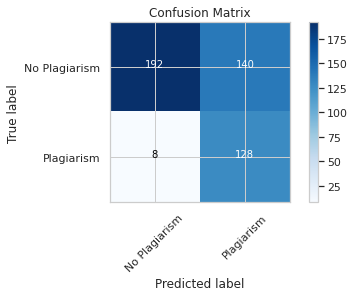

In [ ]:
cm_plot_labels = ['No Plagiarism','Plagiarism']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print("Accuracy",sklearn.metrics.accuracy_score(y_test,seq_predictions))
print("Recall",sklearn.metrics.recall_score(y_test,seq_predictions))
print("ROC AUC",sklearn.metrics.roc_auc_score(y_test,seq_predictions))
print("F1",sklearn.metrics.f1_score(y_test,seq_predictions))

Accuracy 0.6837606837606838
Recall 0.9411764705882353
ROC AUC 0.7597448618001418
F1 0.6336633663366337


***Testing on the B2017 dataset to generate the output***

In [ ]:
from numpy import asarray
# values=[
# 7216624.0,2786.0,1682.0,810.0,499.0,30029.0,18276.0,24492.0,1321.0,0.00542927,10928.0,469.0,0.616049383,3.585377013    
#    ]
test_2017=pd.read_csv('/content/sample_data/plagiarism_student_dataset_test_B2017.csv',index_col=0)
test_2017.index.names=[None]
test_2017.fillna(0,inplace=True)
test_2017.describe()
test_2017=scaler.fit_transform(test_2017)
# values=np.array(values).reshape(-1,1)
# values=scaler.fit_transform(values)
# val=(max(values)+min(values))/2
# print(val)
# print(values)
# input_array = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
# values = np.expand_dims(values,axis=0)
label=loaded_model.predict(test_2017)
val=min(sum(label)/len(label),median(label))
print(label)
for i in label:
  print("Plagiarised" if i>val else "Non Plagiarised")
print(val)
print(label.dtype)
# sns.countplot(label)

[[0.8017603 ]
 [0.808432  ]
 [0.04523888]
 [0.7860495 ]
 [0.80311686]
 [0.80431515]
 [0.3904968 ]
 [0.80883235]
 [0.7916964 ]
 [0.04534081]
 [0.8050811 ]
 [0.04878539]
 [0.8033142 ]
 [0.04451224]
 [0.8033899 ]
 [0.04543582]
 [0.8066152 ]
 [0.80282193]
 [0.046693  ]
 [0.79984903]
 [0.8031783 ]
 [0.804325  ]
 [0.04523215]
 [0.04527128]
 [0.04793254]
 [0.04547253]
 [0.80375165]
 [0.04525322]
 [0.8055739 ]
 [0.16563755]
 [0.76106954]
 [0.80432403]
 [0.8064474 ]
 [0.06870583]
 [0.808813  ]
 [0.13719201]
 [0.80354464]
 [0.04523373]
 [0.80250764]
 [0.04523358]
 [0.8004261 ]
 [0.7796631 ]
 [0.04669365]
 [0.76801646]
 [0.05586854]
 [0.80447626]
 [0.79047966]
 [0.7854789 ]
 [0.80305576]
 [0.8080353 ]
 [0.802177  ]
 [0.8055687 ]
 [0.80223584]
 [0.80342305]
 [0.75898975]
 [0.7137796 ]
 [0.8035396 ]
 [0.540498  ]
 [0.0452337 ]
 [0.04526219]
 [0.8049438 ]
 [0.80621463]
 [0.8037942 ]
 [0.7224908 ]
 [0.04524791]
 [0.04538193]
 [0.04722577]
 [0.13494524]
 [0.4730414 ]
 [0.8066945 ]
 [0.8038046 ]
 [0.44

# ***In conclusion we can say that the model after sampling performs better than the model before sampling with better recall and accuracy***